In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [2]:
# Create a synthetic dataset for this example
RNDSTATE = 42

sig_weight = 0.01
data, labels = make_classification(
    n_samples=12000,
    n_features=30,
    n_redundant=5,
    n_informative=2,
    n_repeated=3,
    random_state=RNDSTATE,
    n_clusters_per_class=1,
    n_classes=2,
    weights=[sig_weight, 1-sig_weight]
)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=RNDSTATE)

In [3]:
# Substract the mean and scale to unit variance
scaler_train = StandardScaler()
scaler_test = StandardScaler()

X_train = scaler_train.fit_transform(X_train)
X_test = scaler_test.fit_transform(X_test)

X_train = tf.cast(X_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)

In [4]:
###################################
# PART I: Feature Space Reduction #
###################################

# Model
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Dense(30, activation="relu"),
          layers.Dense(16, activation="relu"),
          layers.Dense(8, activation="relu")
        ])

        self.decoder = tf.keras.Sequential([
          layers.Dense(16, activation="relu"),
          layers.Dense(24, activation="relu"),
          layers.Dense(30, activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AutoEncoder()

In [5]:
autoencoder.compile(optimizer='adam', loss='mae')

# Model weights are saved at the end of every epoch, if it's the best seen so far
checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

EPOCHS = 100
history = autoencoder.fit(
    X_train,
    X_train, 
    epochs=EPOCHS, 
    batch_size=512,
    validation_data=(X_test, X_test),
    shuffle=True,
    callbacks=[model_checkpoint_callback]
)

# We load the best weight into the model
autoencoder.load_weights(checkpoint_filepath)

Epoch 1/100
19/19 [==============================] - 2s 25ms/step - loss: 0.8890 - val_loss: 0.8768
Epoch 2/100
19/19 [==============================] - 0s 10ms/step - loss: 0.8622 - val_loss: 0.8377
Epoch 3/100
19/19 [==============================] - 0s 11ms/step - loss: 0.8181 - val_loss: 0.7943
Epoch 4/100
19/19 [==============================] - 0s 11ms/step - loss: 0.7880 - val_loss: 0.7781
Epoch 5/100
19/19 [==============================] - 0s 10ms/step - loss: 0.7767 - val_loss: 0.7685
Epoch 6/100
19/19 [==============================] - 0s 11ms/step - loss: 0.7658 - val_loss: 0.7560
Epoch 7/100
19/19 [==============================] - 0s 11ms/step - loss: 0.7502 - val_loss: 0.7384
Epoch 8/100
19/19 [==============================] - 0s 11ms/step - loss: 0.7324 - val_loss: 0.7239
Epoch 9/100
19/19 [==============================] - 0s 10ms/step - loss: 0.7233 - val_loss: 0.7198
Epoch 10/100
19/19 [==============================] - 0s 11ms/step - loss: 0.7204 - val_loss: 0.7179

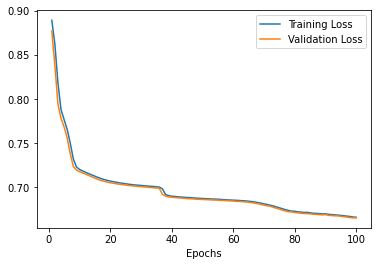

In [6]:
# Ploting the training/validation loss scores
xaxis = list(range(1, EPOCHS + 1))

plt.plot(xaxis, history.history["loss"], label="Training Loss")
plt.plot(xaxis, history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epochs')
plt.legend()

In [7]:
######################################
# PART II: Classification comparison #
######################################

# We reduce/compress our feature space thanks to our trained AE
X_train_rfs = autoencoder.encoder(X_train).numpy()
X_test_rfs = autoencoder.encoder(X_test).numpy()

# GBT parameters
PARAM = {
    'max_depth': 3,
    'n_estimators': 100,
    'random_state': RNDSTATE
}

gbt = GradientBoostingClassifier(**PARAM)
gbt.fit(X_train_rfs, y_train)        # training on reduced feature space (rfs)

# GBT prediction on reduced test data
y_pred = gbt.predict(X_test_rfs)

In [8]:
# Training on the oringal train dataset (after re-scaling)
gbt2 = GradientBoostingClassifier(**PARAM)
gbt2.fit(X_train.numpy(), y_train)

# GBT2 prediction on NOT-reduced test data
y_pred2 = gbt2.predict(X_test)

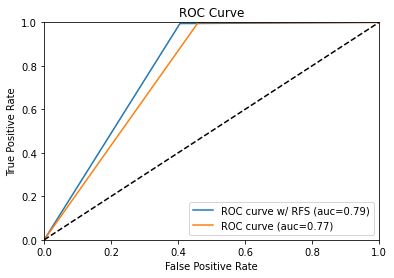

In [9]:
# Ploting the receiver operating characteristic curve for both models
fpr, tpr, _ = roc_curve(y_test, y_pred)
fpr2, tpr2, _2 = roc_curve(y_test, y_pred2)

plt.plot(fpr, tpr, label='ROC curve w/ RFS (auc=%0.2f)' % auc(fpr, tpr))
plt.plot(fpr2, tpr2, label='ROC curve (auc=%0.2f)' % auc(fpr2, tpr2))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.show()